# Comparison of two sleep classifiers with LOOX

In this notebook, we analyze the performance of logistic regression on _Walch et al._ and a modified form we call the "hybrid motion" data set. This data set was created by taking triaxial accelerometer sampled at 50 Hz and combining with the gyroscopic measurements from a Naval platform to capture ship rotational and vibrational noise. 

We further compare logistic regression with the deep UNet model, with best performing open weights, from _Mads Olsen et al._.

Our models output, for each 30 second epoch of input recordings (accelerometer, actigraphy, and/or heart rate and other features) a probability of a particular epoch of recording corresponding to a `sleep` PSG label. When running inference to group the epochs into periods of sleep and wake (or sleep stages), we set a threshold for this probability, above which we predict an epoch sleep. For example, if a model outputs `0.71` (probability of sleep) for a given epoch, then a threshold of `0.5` will send this prediction to `sleep` since `0.71 > 0.5`, whereas a more stringent threshold of `0.76` would return a prediction of `wake` since `0.71 <= 0.76`. 

An ROC curve captures this trade-off that comes with the threshold, and also captures the fact that it's not so important that the model has probabilities spanning 0 to 1; even if the model only outputs predictions between 0.7 and 0.8, we could still pick an optimal threshold between those values as the cut-off for `sleep` or `wake` differentiation.


The metrics we will use are:
1. **AUROC**: area under ROC. 

    This is a useful way to evaluate prediction power of a trained model in highly class-imbalanced data, such as our recordings which are mostly people asleep with brief awakenings at the beginning and end, and a few places in the middle, of the recording.
2. **WASA93**: Wake accuracy when sleep accuracy is at least 93%. 

    Recalling the trade-off between scoring each class accurately and not missing epochs, for WASA93 we choose a threshold makign sleep accuracy (total fraction scored correct) at least 0.93% and then evalute the wake epochs with that threshold. This score is one way of quantifying the reliability of the prediction, especially in high-risk scenarios where monitoring awakenings during schedule sleep hours is important.

3. **Cohen's kappa**: A classical statistic that quantifies the amount to which the labels predicted (at various thresholds) have "random" agreement with the true labels. For example, when a model simply outputs the same class (ie everything is reported as `sleep`, independent of input) the kappa returns the fraction of true labels that take on that class.

# Setup & Preprocessing

We will set up some variables we'll re-use a lot, as well as preprocess the acelerometer data into spectrograms and save that data, along with its labels, in a pickled iterator.

In [2]:
!pisces_setup

2024-10-03 16:09:55.450145: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 16:09:55.476806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 16:09:55.985124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Converting Mads Olsen model to Keras...
2024-10-03 16:09:56.862406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returni

In [3]:
import numpy as np
import tensorflow as tf
import pisces.models as pm
from matplotlib import pyplot as plt
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType

2024-10-03 16:09:58.214670: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 16:09:58.241343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 16:09:58.744787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set up paths for caching
Set up all the paths here, ensure the (sub)folders all exist so later when we try to save to these there are no errors.

In [4]:

import os
from pathlib import Path

CWD = Path(os.getcwd())
save_path = CWD.joinpath("pre_processed_data")
hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)
data_location = CWD.parent.joinpath('data_sets')#CWD.parent.joinpath("data_sets")

walch_preprocessed_path = walch_path.joinpath("walch_preprocessed_data.npy")
hybrid_preprocessed_path = hybrid_path.joinpath("hybrid_preprocessed_data.npy")


In [5]:

split_maker = pm.LeaveOneOutSplitter()

In [6]:
data_location

PosixPath('/home/eric/Engineering/Work/pisces/data_sets')

In [7]:
def make_mo_model_and_processor(data_set):
    sampling_hz = 32 # Hz
    input_features = ['accelerometer']
    model_input = ModelInputSpectrogram(input_features, sampling_hz)
    output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
    data_processor = DataProcessor(data_set, 
                                    model_input, 
                                    output_type=output_type,
                                    psg_type=PSGType.HAS_N4)
    mo = pm.MOResUNetPretrained(data_processor=data_processor, sampling_hz=sampling_hz)

    return mo, data_processor
def preprocess_if_needed(data_set, save_preprocessing_to, subjects_to_exclude):
    if save_preprocessing_to.exists():
        print(f"Preprocessed data found at {save_preprocessing_to}.\nSkipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.")
        return
    else:
        mo, _ = make_mo_model_and_processor(data_set)
        ids_to_preprocess = [id for id in data_set.ids if id not in subjects_to_exclude]
        preprocessed_data = [mo.get_needed_X_y(id, mo.data_processor) for id in ids_to_preprocess]
        # Prepare a bundle to save
        to_save = {
            id: data
            for (data, id) in zip(preprocessed_data, ids_to_preprocess)
            if data is not None
        }
        print(f"Saving to {save_preprocessing_to}...")
        np.save(save_preprocessing_to,
                np.array(to_save, dtype=object)
                )

## Walch

In [8]:
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects. (Should be 31)")

Found 31 subjects. (Should be 31)


In [9]:
subjects_to_exclude_walch = [
    "759667", "3509524", "7749105",
    "9961348", "5132496",
]
ids_to_split = [id for id in walch.ids if id not in subjects_to_exclude_walch]

In [10]:
preprocess_if_needed(walch, walch_preprocessed_path, subjects_to_exclude_walch)

Preprocessed data found at /home/eric/Engineering/Work/pisces/analyses/pre_processed_data/walch/walch_preprocessed_data.npy.
Skipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.


## Hybrid

In [11]:
# hybrid are a manipulation of the walch data set
# hence we want to exclude the same ones, for the same reasons
subjects_to_exclude_hybrid = subjects_to_exclude_walch

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects. (Should be 31, matching walch)")
 

Found 31 subjects. (Should be 31, matching walch)


In [12]:
preprocess_if_needed(hybrid, hybrid_preprocessed_path, subjects_to_exclude_hybrid)

Preprocessed data found at /home/eric/Engineering/Work/pisces/analyses/pre_processed_data/hybrid/hybrid_preprocessed_data.npy.
Skipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.


# Hypnogram exploration

In [13]:
preprocessed_data_unet = {
    walch.name: np.load(walch_preprocessed_path, allow_pickle=True).item(),
    hybrid.name: np.load(hybrid_preprocessed_path, allow_pickle=True).item(),
}

In [14]:
mo, proc = make_mo_model_and_processor(walch)
mo.load_model()

2024-10-03 16:10:00.073078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-03 16:10:00.092145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-03 16:10:00.092268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [15]:
walch_data = preprocessed_data_unet[walch.name]

In [16]:
w0_X, w0_y = walch_data[walch.ids[0]]

In [17]:
prediction = mo.predict_probabilities(w0_X)

I0000 00:00:1727989801.640994   77288 service.cc:145] XLA service 0x7d2380002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727989801.641017   77288 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-03 16:10:01.666841: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 16:10:01.779910: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1727989803.675332   77288 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [18]:
prediction.shape

(1024, 4)

In [19]:
w0_y.shape

(1024,)

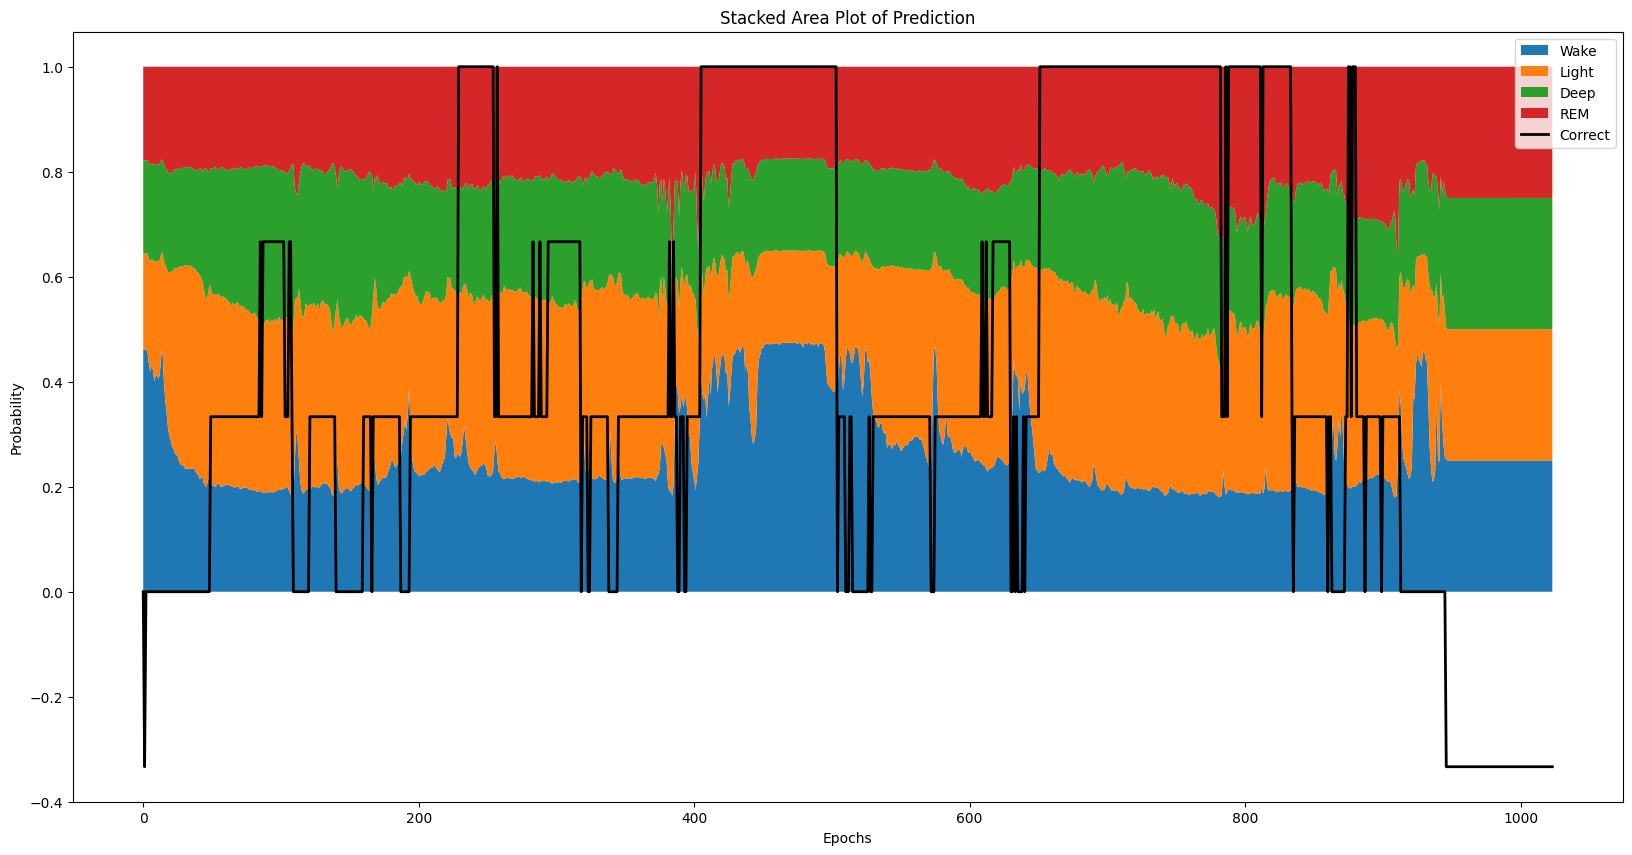

In [20]:
plt.figure(figsize=(20, 10))
plt.stackplot(range(prediction.shape[0]), prediction.T, labels=["Wake", "Light", "Deep", "REM"])
plt.plot(w0_y / 3, label="Correct", color='black', linewidth=2)
plt.legend(loc='upper right')
plt.title("Stacked Area Plot of Prediction")
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Reshape

# Define the model
def create_sequential_model(input_shape, layer_dims, output_dims=2):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for dim in layer_dims:
        model.add(Dense(dim, activation='linear'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.01))
    model.add(Dense(output_dims, activation='softmax'))
    return model


In [24]:
evaluated_data = [mo.predict_probabilities(data[0]) for data in walch_data.values()]

evaluated_labels = [data[1] for data in walch_data.values()]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [27]:
evaluated_data[0].shape

(1024, 4)

In [26]:
evaluated_labels[0].shape

(1024,)

In [28]:
np.concatenate(evaluated_data).shape

(26624, 4)

In [25]:
model = create_sequential_model(
    input_shape=(1024, 4), 
    layer_dims=[64, 64, 64],
    output_dims=2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

splits = split_maker.split(evaluated_data)

for train, test in splits:
    train_data = [evaluated_data[i] for i in train]
    test_data = [evaluated_data[i] for i in test]

    train_labels = [evaluated_labels[i] for i in train]
    test_labels = [evaluated_labels[i] for i in test]

    X_train = np.concatenate(train_data)
    X_test = np.concatenate(test_data)

    y_train = np.concatenate(train_labels)
    y_test = np.concatenate(test_labels)

    model.fit(X_train, y_train, epochs=10)
    model.evaluate(X_test, y_test)

Epoch 1/10


/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/eric/miniconda3/envs/pisces/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 4), dtype=float32). Expected shape (None, 1024, 4), but input has incompatible shape (32, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 4), dtype=float32)
  • training=True
  • mask=None

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(1 - prediction[:, 0], label="Wake")
plt.plot(w0_y, label="True")

plt.legend()


# Logistic Regression

In [12]:
# Train with top scoring hyperparameters
from typing import Callable, Tuple


log_reg_hyperparameters = {
    'penalty': None,
    'alpha': 10,
    'fit_intercept': False,
    'learning_rate': 'adaptive',
    'eta0': 0.0001,
    'random_state': 42,
}


def make_lr_model(data_set: DataSetObject, **log_reg_hyperparameters) -> Tuple[Callable, DataProcessor]:

    sampling_hz = 1.0 / 15.0
    output_type = pm.ModelOutputType.SLEEP_WAKE
    window_size_seconds = 300
    input_features = ['activity']
    max_iter = 2000
    class_weight = "balanced"
    n_iter_no_change = 15
    model_input = pm.ModelInput1D(input_features, sampling_hz, window_size_seconds)
    data_processor = DataProcessor(data_set, model_input, output_type=output_type)
    def model_fn():
        return pm.SGDLinearClassifier(data_processor, **log_reg_hyperparameters)
    return model_fn, data_processor

For the purposes of using LOO and LOOX cross-validation, we need to have both LR preprocessed data loaded, for passing into our evaluation functions.

In [ ]:
from tqdm import tqdm


swc_walch_fn, walch_data_processor_1D = make_lr_model(walch, **log_reg_hyperparameters)
swc_hybrid_fn, walch_data_processor_1D = make_lr_model(hybrid, **log_reg_hyperparameters)
swc_walch = swc_walch_fn()
swc_hybrid = swc_hybrid_fn()
tqdm_message_preprocess = f"Preparing data for {len(ids_to_split)} IDs"
preprocessed_data_log_reg = {
    walch.name:  {id: swc_walch.get_needed_X_y(id) for id in tqdm(ids_to_split, desc=tqdm_message_preprocess)},
    hybrid.name:  {id: swc_hybrid.get_needed_X_y(id) for id in tqdm(ids_to_split, desc=tqdm_message_preprocess)},
}

In [ ]:
TRAIN_SET = walch.name
EVAL_SET = walch.name
PLOT_TITLE = f'Top scorer evaluated on {EVAL_SET}, trained on {TRAIN_SET}'

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

models = []
splits = []

model_fn, _ = make_lr_model(walch, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_log_reg[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_log_reg[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    model, _ = pm.run_split(train_indices=train_ids, 
                            preprocessed_data_set=training_preprocessed_data, 
                            swc=model_fn(), epochs=None, do_not_train=False)
    models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
TRAIN_SET = walch.name
EVAL_SET = hybrid.name
PLOT_TITLE = f'Top scorer evaluated on {EVAL_SET}, trained on {TRAIN_SET}'

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

models = []
splits = []

model_fn, _ = make_lr_model(hybrid, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_log_reg[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_log_reg[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    model, _ = pm.run_split(train_indices=train_ids, 
                            preprocessed_data_set=training_preprocessed_data, 
                            swc=model_fn(), epochs=None)
    models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()

# Deep UNet from Mads Olsen's group

In [17]:
text_indices = [walch.ids[0]]
train_indices = [i for i in walch.ids[1:] if i not in subjects_to_exclude_walch]
preprocessed_data_set = preprocessed_data_unet[walch.name]
training_pairs = [
    [preprocessed_data_set[i][0], preprocessed_data_set[i][1].reshape(1, -1)]
    # [preprocessed_data_set[i][0], preprocessed_data_set[i][1]]
    for i in train_indices
    if preprocessed_data_set.get(i) is not None
]

In [ ]:
mo, _ = make_mo_model_and_processor(walch)
mo.initial_lr = 0.00001
mo.load_model()
swc = mo
extra_params = {
    f'{swc.model_pipeline_name}__epochs': 100,
    f'{swc.model_pipeline_name}__batch_size': 1,
    f'{swc.model_pipeline_name}__validation_split': 0.1
}
print(swc.pipeline.named_steps)
result = swc.train(pairs_Xy=training_pairs, **extra_params)

In [ ]:
TRAIN_SET = walch.name
EVAL_SET = walch.name
PLOT_TITLE = f"Mads Olsen's UNet evaluated on {EVAL_SET}"

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

# mo, _ = make_mo_model_and_processor(walch)
# mo.load_model()
models = [swc]
splits = []
# model_fn = make_model(walch_data_processor_1D, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_unet[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_unet[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    # model, _ = pm.run_split(train_indices=train_ids, 
    #                         preprocessed_data_set=training_preprocessed_data, 
    #                         swc=mo, epochs=0, do_not_train=True)
    # models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
TRAIN_SET = walch.name
EVAL_SET = hybrid.name
PLOT_TITLE = f"Mads Olsen's UNet evaluated on {EVAL_SET}"

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

mo, _ = make_mo_model_and_processor(walch)
mo.load_model()
models = [mo]
splits = []
# model_fn = make_model(walch_data_processor_1D, **log_reg_hyperparameters)

training_preprocessed_data = preprocessed_data_unet[TRAIN_SET]
evaluate_preprocessed_data = preprocessed_data_unet[EVAL_SET]
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    train_ids = list(map(lambda i: ids_to_split[i], train_index)) #ids_to_split[test_index[0]]
    test_ids = list(map(lambda i: ids_to_split[i], test_index)) #ids_to_split[test_index[0]]
    # model, _ = pm.run_split(train_indices=train_ids, 
    #                         preprocessed_data_set=training_preprocessed_data, 
    #                         swc=mo, epochs=0, do_not_train=True)
    # models.append(model)
    splits.append([train_ids, test_ids])

metrics = calculate_metrics_from_splits(evaluate_preprocessed_data, models, splits)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle(PLOT_TITLE,
             fontsize=20)
plt.tight_layout()
plt.show()